## Making Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.optim as optim

## Implementing Dataset Class

In [3]:
class LOLDataset(Dataset):
    def __init__(self, low_light_dir, normal_light_dir, transform=None, augment=True):
        self.low_light_dir = low_light_dir
        self.normal_light_dir = normal_light_dir
        self.transform = transform
        self.augment = augment

        # Get list of image filenames
        self.image_filenames = sorted(os.listdir(self.low_light_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]

        low_light_path = os.path.join(self.low_light_dir, img_name)
        normal_light_path = os.path.join(self.normal_light_dir, img_name)

        low_light_img = Image.open(low_light_path).convert('RGB')
        normal_light_img = Image.open(normal_light_path).convert('RGB')

        # Apply transforms
        if self.transform:
            low_light_img = self.transform(low_light_img)
            normal_light_img = self.transform(normal_light_img)

        # Apply augmentations synchronously
        if self.augment:
            # Random horizontal flip
            if random.random() < 0.2:
                low_light_img = TF.hflip(low_light_img)
                normal_light_img = TF.hflip(normal_light_img)

            # Random vertical flip
            if random.random() < 0.2:
                low_light_img = TF.vflip(low_light_img)
                normal_light_img = TF.vflip(normal_light_img)

            # Random rotation
            angle = random.choice([0, 90, 180, 270])  
            low_light_img = TF.rotate(low_light_img, angle)
            normal_light_img = TF.rotate(normal_light_img, angle)

        return low_light_img, normal_light_img

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [5]:
# Dataset paths
train_low_light_dir = "/kaggle/input/lol-dataset/lol_dataset/our485/low"
train_normal_light_dir = "/kaggle/input/lol-dataset/lol_dataset/our485/high"

eval_low_light_dir = "/kaggle/input/lol-dataset/lol_dataset/eval15/low"
eval_normal_light_dir = "/kaggle/input/lol-dataset/lol_dataset/eval15/high"

In [6]:
train_dataset = LOLDataset(train_low_light_dir, train_normal_light_dir, transform=train_transforms, augment=True)
val_dataset = LOLDataset(eval_low_light_dir, eval_normal_light_dir, transform=val_transforms, augment=False)

In [7]:
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=8, shuffle=False)

Sanity Check

In [8]:
# Check a batch
low_light, normal_light = next(iter(train_dl))
print("Low-light image shape:", low_light.shape)
print("Normal-light image shape:", normal_light.shape)

Low-light image shape: torch.Size([32, 3, 256, 256])
Normal-light image shape: torch.Size([32, 3, 256, 256])


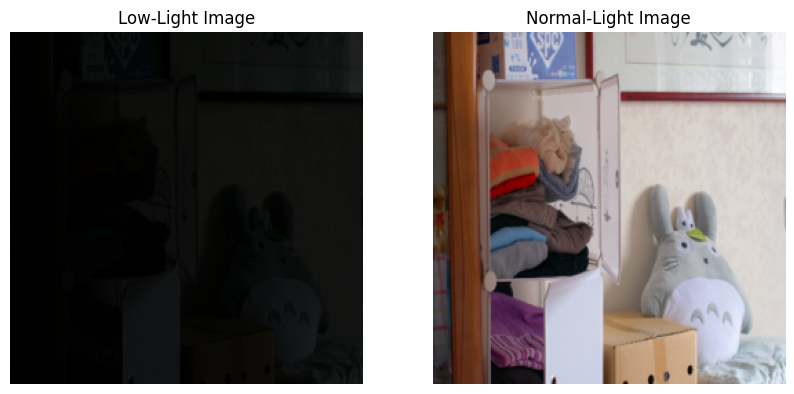

In [9]:
def visualize_sample(dataloader):
    # Get a random batch
    low_light, normal_light = next(iter(dataloader))
    idx = random.randint(0, low_light.shape[0] - 1)
    low_light_img = low_light[idx].permute(1, 2, 0).cpu().numpy()
    normal_light_img = normal_light[idx].permute(1, 2, 0).cpu().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(low_light_img)
    ax[0].set_title("Low-Light Image")
    ax[0].axis("off")
    
    ax[1].imshow(normal_light_img)
    ax[1].set_title("Normal-Light Image")
    ax[1].axis("off")
    
    plt.show()

visualize_sample(val_dl)

## Implementing the Model

In [10]:
class ZeroDCE(nn.Module):
    def __init__(self):
        super(ZeroDCE, self).__init__()

        # 8 convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        A = torch.tanh(self.conv8(x))  

        return A

In [11]:
def enhance_image(I_low, A, iterations=8):
    I_enh = I_low
    for _ in range(iterations):
        I_enh = I_enh + A * I_enh * (1 - I_enh)
    return I_enh


In [12]:
class ZeroDCELoss(nn.Module):
    def __init__(self):
        super(ZeroDCELoss, self).__init__()

    def spatial_consistency_loss(self, I_enh, I_low):
        """Encourages spatial smoothness in the enhanced image."""
        return torch.mean(torch.abs(I_enh - I_low))

    def exposure_loss(self, I_enh, target_mean=0.6):
        """Encourages correct exposure by aligning mean brightness."""
        mean_brightness = torch.mean(I_enh, dim=[1, 2, 3])
        return torch.mean((mean_brightness - target_mean) ** 2)

    def color_constancy_loss(self, I_enh):
        """Encourages color balance by reducing color shifts."""
        R, G, B = I_enh[:, 0, :, :], I_enh[:, 1, :, :], I_enh[:, 2, :, :]
        loss = torch.mean(torch.abs(R - G)) + torch.mean(torch.abs(G - B)) + torch.mean(torch.abs(B - R))
        return loss

    def illumination_smoothness_loss(self, A):
        """Prevents overly aggressive enhancement."""
        loss = torch.mean(torch.abs(A[:, :, :-1, :] - A[:, :, 1:, :])) + \
               torch.mean(torch.abs(A[:, :, :, :-1] - A[:, :, :, 1:]))
        return loss

    def forward(self, I_low, I_enh, A):
        """Computes the total loss."""
        loss_s = self.spatial_consistency_loss(I_enh, I_low)
        loss_e = self.exposure_loss(I_enh)
        loss_c = self.color_constancy_loss(I_enh)
        loss_i = self.illumination_smoothness_loss(A)

        # Weighted sum of losses
        total_loss = loss_s + 10 * loss_e + 1 * loss_c + 0.1 * loss_i
        return total_loss

In [13]:
def brightness_contrast_metrics(image_tensor):
    # Convert to grayscale using luminance formula
    grayscale_image = 0.2989 * image_tensor[:, 0, :, :] + \
                      0.5870 * image_tensor[:, 1, :, :] + \
                      0.1140 * image_tensor[:, 2, :, :]

    # Compute brightness (mean pixel intensity)
    brightness = grayscale_image.mean(dim=[1, 2]).tolist()  # Convert to list of scalars

    # Compute contrast (standard deviation of pixel intensities)
    contrast = grayscale_image.std(dim=[1, 2]).tolist()  

    return brightness, contrast  


In [14]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ZeroDCE().to(device)
criterion = ZeroDCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Training Loop

In [15]:
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    # Training Phase
    for I_low, _ in train_dl:  
        I_low = I_low.to(device)

        # Forward pass
        A = model(I_low)
        I_enh = enhance_image(I_low, A)

        # Compute loss
        loss = criterion(I_low, I_enh, A)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_dl)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Validation Phase
    model.eval()
    with torch.no_grad():
        val_loss = 0
        brightness_before, brightness_after = [], []
        contrast_before, contrast_after = [], []

        for I_low, _ in val_dl:
            I_low = I_low.to(device)

            A = model(I_low)
            I_enh = enhance_image(I_low, A)

            loss = criterion(I_low, I_enh, A)
            val_loss += loss.item()

            # Compute Brightness & Contrast
            b1, c1 = brightness_contrast_metrics(I_low.cpu())
            b2, c2 = brightness_contrast_metrics(I_enh.cpu())

            brightness_before.extend(b1)
            brightness_after.extend(b2)
            contrast_before.extend(c1)
            contrast_after.extend(c2)

        avg_val_loss = val_loss / len(val_dl)
        avg_brightness_before = sum(brightness_before) / len(brightness_before)
        avg_brightness_after = sum(brightness_after) / len(brightness_after)
        avg_contrast_before = sum(contrast_before) / len(contrast_before)
        avg_contrast_after = sum(contrast_after) / len(contrast_after)

        val_losses.append(avg_val_loss)

        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Brightness (Before: {avg_brightness_before:.3f}, After: {avg_brightness_after:.3f})")
        print(f"Contrast (Before: {avg_contrast_before:.3f}, After: {avg_contrast_after:.3f})")

    print("-" * 50)

Epoch 1/10, Train Loss: 2.8076
Validation Loss: 2.7553
Brightness (Before: 0.060, After: 0.086)
Contrast (Before: 0.038, After: 0.052)
--------------------------------------------------
Epoch 2/10, Train Loss: 2.6786
Validation Loss: 2.5631
Brightness (Before: 0.060, After: 0.111)
Contrast (Before: 0.038, After: 0.066)
--------------------------------------------------
Epoch 3/10, Train Loss: 2.3301
Validation Loss: 1.6550
Brightness (Before: 0.060, After: 0.277)
Contrast (Before: 0.038, After: 0.146)
--------------------------------------------------
Epoch 4/10, Train Loss: 1.3440
Validation Loss: 1.0764
Brightness (Before: 0.060, After: 0.642)
Contrast (Before: 0.038, After: 0.232)
--------------------------------------------------
Epoch 5/10, Train Loss: 1.1267
Validation Loss: 0.9935
Brightness (Before: 0.060, After: 0.534)
Contrast (Before: 0.038, After: 0.217)
--------------------------------------------------
Epoch 6/10, Train Loss: 1.1038
Validation Loss: 0.9722
Brightness (Bef

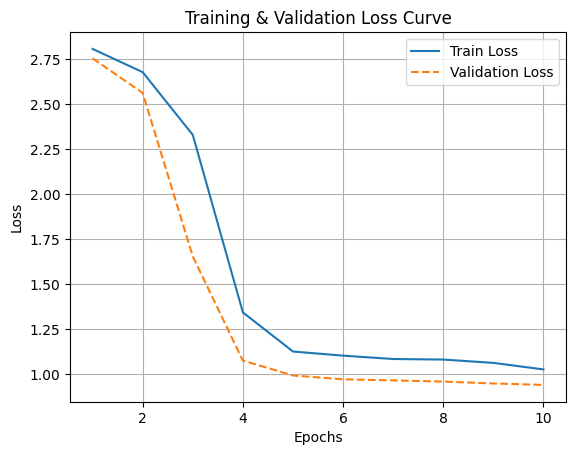

In [16]:
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", linestyle="dashed")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

## Results

1. Visual Inspection

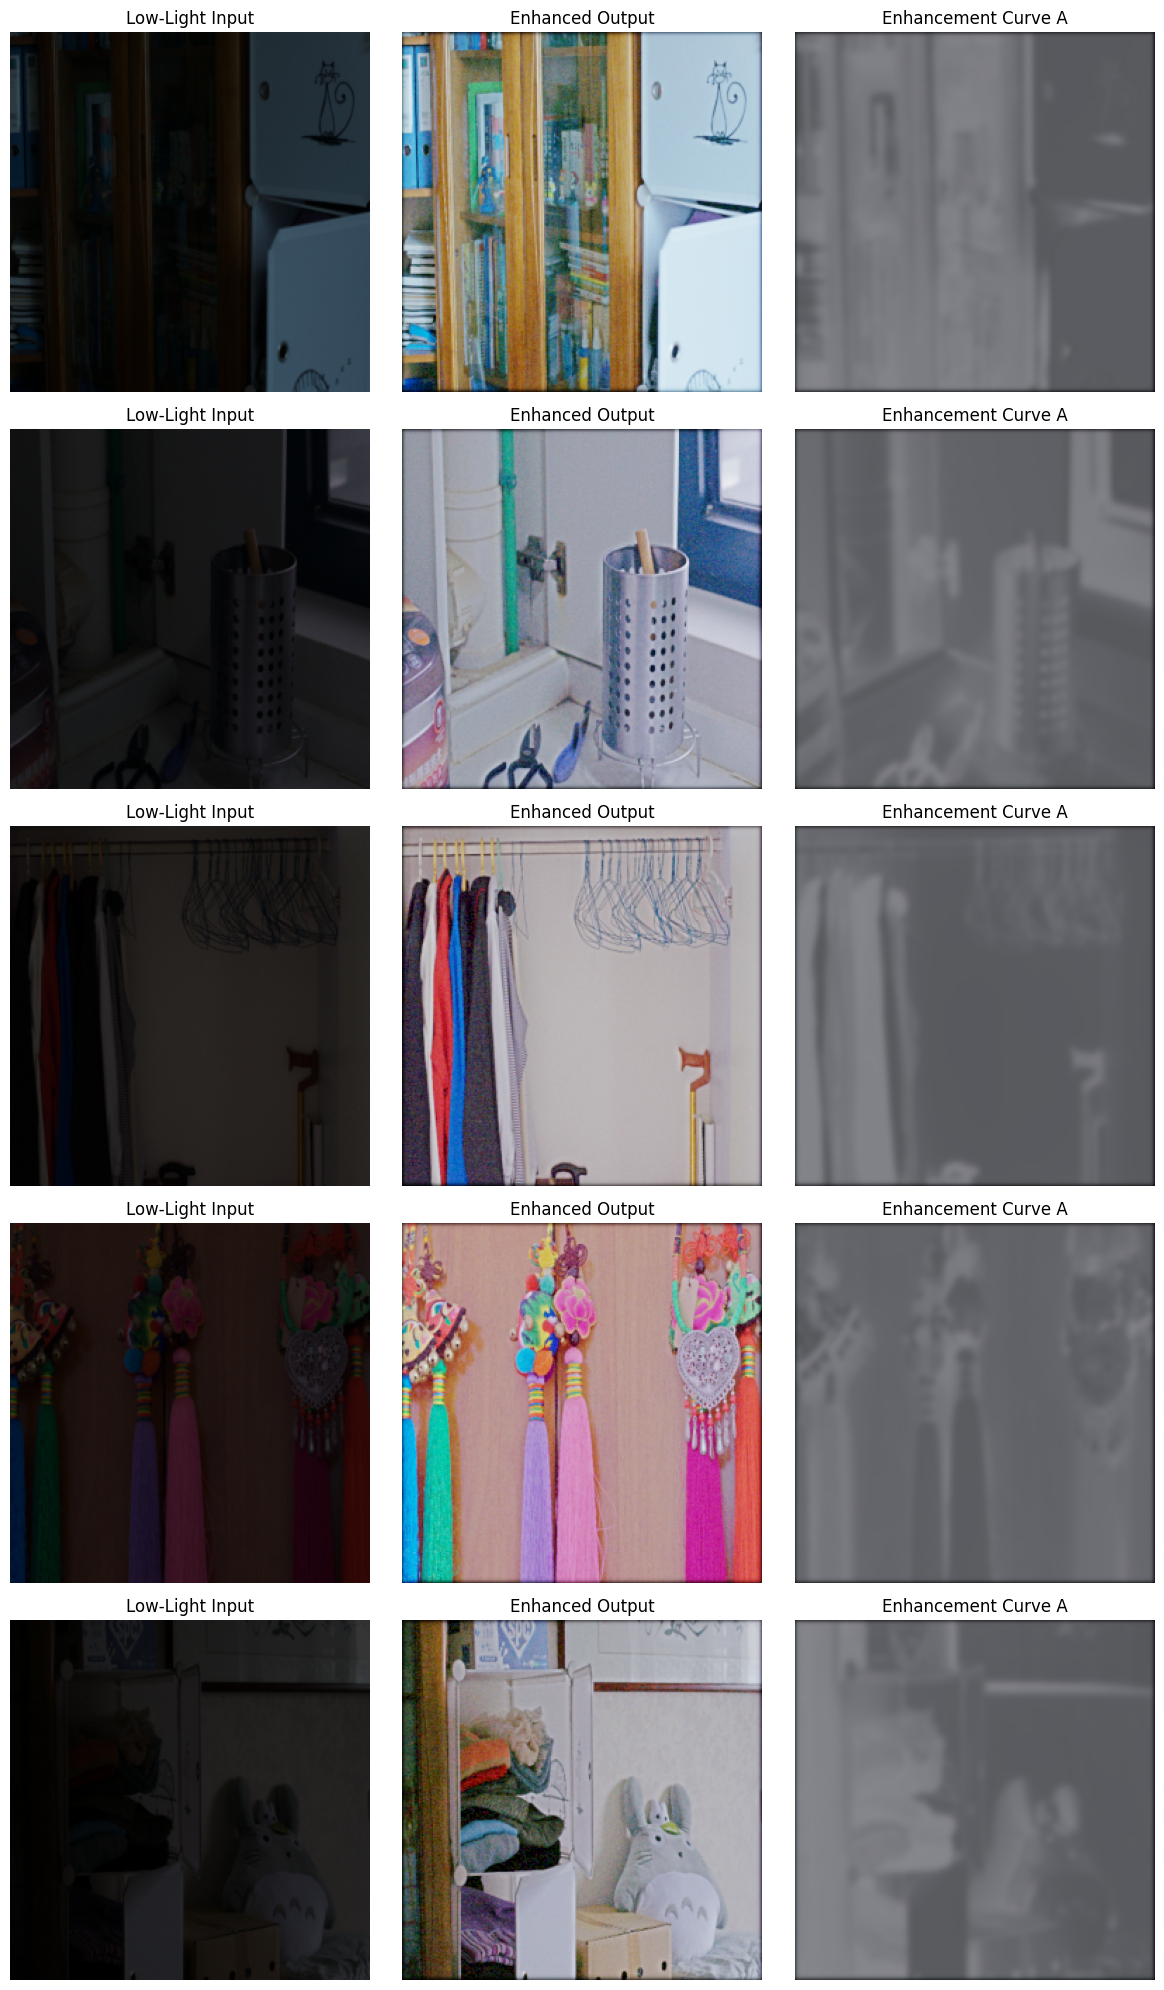

In [17]:
def visualize_results(model, dataset, num_samples=5):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    
    for i in range(num_samples):
        low_light_img, _ = dataset[i]
        low_light_img = low_light_img.unsqueeze(0).to(device)  
        
        with torch.no_grad():
            A = model(low_light_img)
            enhanced_img = enhance_image(low_light_img, A)

        low_light_img = low_light_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
        enhanced_img = enhanced_img.squeeze(0).permute(1, 2, 0).cpu().numpy()

        axes[i, 0].imshow(low_light_img)
        axes[i, 0].set_title("Low-Light Input")
        
        axes[i, 1].imshow(enhanced_img)
        axes[i, 1].set_title("Enhanced Output")
        
        axes[i, 2].imshow(A.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title("Enhancement Curve A")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_results(model, val_dataset, num_samples=5)

## Evaluation Metrics

In [18]:
pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [19]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import piq  
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm

def evaluate_metrics(model, val_dataset, device):
    model.eval()
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    psnr_scores = []
    ssim_scores = []

    with torch.no_grad():
        for low_light, normal_light in tqdm(val_loader, desc="Evaluating"):
            low_light, normal_light = low_light.to(device), normal_light.to(device)
            enhanced_img = model(low_light).clamp(0, 1)  
            psnr_value = psnr(
                normal_light.squeeze().cpu().numpy().transpose(1, 2, 0),
                enhanced_img.squeeze().cpu().numpy().transpose(1, 2, 0),
                data_range=1.0
            )
            psnr_scores.append(psnr_value)
            ssim_value = piq.ssim(enhanced_img, normal_light, data_range=1.0).item()
            ssim_scores.append(ssim_value)

    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)

    print(f"PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")
    return avg_psnr, avg_ssim


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training metrics:")
evaluate_metrics(model, train_dataset, device)

print("Validation metrics:")
evaluate_metrics(model, val_dataset, device)

Training metrics:


Evaluating: 100%|██████████| 485/485 [00:14<00:00, 32.88it/s]


PSNR: 12.32, SSIM: 0.4338
Validation metrics:


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.13it/s]

PSNR: 11.54, SSIM: 0.3988


(11.542488405362118, 0.3988496373097102)